---

## Movie_Rating_Analysis



#### Data Manager

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import datetime

import re
import sentiments_nrc
from sentiments_nrc import SENTIMENTS
from sentiments_nrc import EMOTIONS
import seaborn as sns

In [2]:
reviews = pd.read_csv('../data/reviews.csv')
movies = pd.read_csv("../data/movies.dat", delimiter='\t')

In [3]:
### pre data cleaning for reviews data
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
reviews['review_date']=pd.to_datetime(reviews['review_date']).dt.date
reviews=reviews.drop(['link'], axis=1)

In [4]:
### pre data cleaning for movies data
movies= movies.drop(['imdbPictureURL','spanishTitle','rtPictureURL'], axis=1)
# drop movies with unknow or non-numeric values 
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(pd.to_numeric, errors='drop')
movies['rtAllCriticsNumReviews'] = movies['rtAllCriticsNumReviews'].apply(pd.to_numeric, errors = 'drop')
movies['rtAudienceRating'] = movies['rtAudienceRating'].apply(pd.to_numeric, errors= 'drop')

In [5]:
reviews.head(2)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy Story
1,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy Story


In [6]:
movies.head(2)

,id,title,imdbID,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore
0,1,Toy story,114709,1995,toy_story,9.0,73.0,73,0,100,8.5,17,17,0,100,3.7,102338,81
1,2,Jumanji,113497,1995,1068044-jumanji,5.6,28.0,13,15,46,5.8,5,2,3,40,3.2,44587,61


In [7]:
sub_movies=movies[['title', 'imdbID', 'year', 'rtID','rtAllCriticsRating','rtAllCriticsNumReviews','rtAudienceNumRatings', 'rtAudienceScore']]

In [8]:
sub_movies.head(1)

,title,imdbID,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAudienceNumRatings,rtAudienceScore
0,Toy story,114709,1995,toy_story,9.0,73.0,102338,81


#### Visualization Manager I 

Please input two critics that you are interested in: 
1940
1980


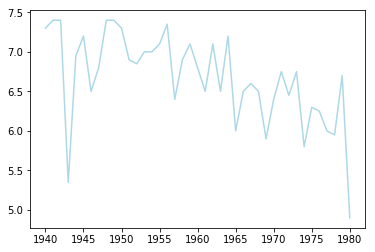

In [16]:
#### interactive one: draw the trendline of the median rating given a time interval 

def draw_trend_line_median_year(sub_movies):
    
    print('Please input two critics that you are interested in: ')
    
    start_year = int(input())
    end_year = int(input())
    

    
    year_median = sub_movies.groupby('year')['rtAllCriticsRating'].median().reset_index()
    year_show = year_median[year_median['year'] >= start_year]
    year_show = year_show[year_median['year'] <= end_year]
    plt.plot(year_show['year'], year_show['rtAllCriticsRating'], color='lightblue')
    plt.show()
    
draw_trend_line_median_year(sub_movies)

#### Visualization Manager II

In [17]:
#### interactive 2: sentiment analysis  for reviews of per critic 

### global variables 
movies_sub=movies[['title','imdbID']]
movie_review=reviews.merge(movies_sub, left_on='imdb', right_on='imdbID', how='inner')
movie_review=movie_review[['critic','publication','quote','review_date','title_x','imdb']]
EMOTIONS = ['positive', 'negative', 'anger', 
            'anticipation', 'disgust', 'fear', 
            'joy', 'sadness', 'surprise', 'trust']

# support function 1
def words_with_specific_emotion(list_of_split_words,emotion):
    '''Produce a list that include the words that contain a specific emotion
       Parameters: list_of_split_words (String): A list with split words 
                   emotion(string): the emotion words in EMOTIONS list
       Returns: list: the words in the string with one certain kind of emotion'''
    Look_Up=[SENTIMENTS.get(word) for word in list_of_split_words] #get the emotion list of every word in the list 
    Combine=list(zip(list_of_split_words,Look_Up)) # zip the emotion list with word in one list 
    Words_With_Specific_Emotion=[line[0] for line in Combine if line[1] is not None and line[1].get(emotion)==1 ]
    return Words_With_Specific_Emotion #find the words in a specific emotion

# support function 2
def words_list_for_each_emotion(Split_Test_String):
    '''Produce a disctionary with emotion words as keys and words list having that emotion as values
       Parameters: Split_Test_String (String): A list with split words
       Returns: list-the  most common words in the input list'''
    matching_words=[words_with_specific_emotion(Split_Test_String,emotion) for emotion in EMOTIONS]
    distinct_matching=[i for i in matching_words]
    return {emotion:matching_word for (emotion,matching_word) in zip(EMOTIONS,distinct_matching)}

# support function 3 
def get_common_words_list(wordlist):
    '''Produce a list with the most common words of the input list
       Parameters: wordlist (string): 
       Returns: dict: the key-values pairs of emotions word and its corresponding words in the string'''
    wordfreq=list(zip(wordlist,[wordlist.count(w) for w in wordlist]))
    wordfreq_sort=list(set(sorted(wordfreq,key=lambda freq: freq[1], reverse=True)))
    new_word_freq_sort=sorted(wordfreq_sort,key=lambda freq: freq[1], reverse=True)
    return [i[0] for i in new_word_freq_sort]

## main analysis function 
def analyze_quote(movie_review,criticname):
    
#     criticname = input("Please enter the Critic that you are interested: ")
    critic_quote=movie_review[['critic','quote']]
    quote = critic_quote[critic_quote['critic'] == criticname]
    #### cominbine quotes into one row 
    content=quote.groupby('critic')['quote'].apply(' '.join).reset_index()['quote']
    Split_String=re.split(r'\W+',content[0]) 
    lower_words=[word.lower() for word in Split_String] 
    length_filtered=[word for word in lower_words if len(word)>1]
    
    ### calculate total number or words
    Total_Words=len(length_filtered)
    Words_List_for_Each_Emotion=words_list_for_each_emotion(length_filtered)
    
    result_list=[]
    for i in EMOTIONS:
        result={}
        example_words=[get_common_words_list(value)[:3] for key,value in Words_List_for_Each_Emotion.items() if key==i]
        result['EMOTION']=i
        result['% WORDS']= len(Words_List_for_Each_Emotion[i])/Total_Words
        result['EXAMPLE WORDS']=example_words[0]
        result_list.append(result)
    result=sorted(result_list,key=lambda k:k['% WORDS'],reverse=True)
    
    ### show the result in a table 
    print("{0:<14} {1:<11} {2:35}".format('EMOTION','%WORDS','EXAMPLE WORDS'))
    for line in result:
        emotion=line['EMOTION']
        words_percent=line['% WORDS']
        format_words_percent='{:.2%}'.format(words_percent)
        example_words=line['EXAMPLE WORDS']
        top_example_words=','.join(example_words)
        print("{0:<14} {1:<11} {2:35} ".format(emotion,format_words_percent,top_example_words))



In [18]:
analyze_quote(movie_review,'A.D. Murphy')

EMOTION        %WORDS      EXAMPLE WORDS                      
positive       9.38%       outstanding,excellent,achievement   
joy            4.69%       outstanding,excellent,powerful      
trust          4.69%       excellent,powerful,delightful       
anticipation   4.30%       suspense,powerful,star              
negative       3.12%       outstanding,shark,patronizing       
fear           2.34%       suspense,powerful,murder            
surprise       2.34%       suspense,occasional,hero            
sadness        1.95%       blue,terrific,lower                 
anger          0.78%       powerful,murder                     
disgust        0.78%       powerful,murder                     


In [ ]:
## There are some problem about interactive issues, need to fix latter 
# print('Pleas eneterthe Critic name that you are interested in: ')
# criticname=str(input())
# analyze_quote(movie_review,criticname)

#### Visualization manager Ⅲ

In [19]:
#give several critic names, plot their number of reviews and rating over time
subr=reviews[['critic','imdb']]
subm=movies[['title','imdbID','year','rtAllCriticsRating']]
mr=pd.merge(subr,subm,left_on='imdb',right_on='imdbID')
RateAndCount=mr.groupby(['critic','year'],as_index=False).aggregate({'rtAllCriticsRating': 'mean',
                             'title': 'count'})
RateAndCount.rename(columns={'rtAllCriticsRating':'rating','title':'count'}, inplace=True)

In [20]:
def draw_comparison(RateAndCount):
    
    print('Please input two critics that you are interested in: ')
    
    print('The first one: ')
    first= input()
    
    print('The second one: ')
    second = input()
    
    if not(first in set(RateAndCount['critic']) and second in set(RateAndCount['critic'])):
        print ('Correct your spelling')
    else:
        fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(15,15))

       
        
        ax[0].title.set_text('Rating comparison')
        RateAndCount[RateAndCount['critic']==first].plot('year','rating',label=first,ax=ax[0])
        RateAndCount[RateAndCount['critic']==second].plot('year','rating',label=second,ax=ax[0])


        ax[1].title.set_text('Number of reviews comparison')
        ax[1]=sns.regplot('year','count',RateAndCount[RateAndCount['critic']==first],fit_reg=False,marker="+",label=first)
        ax[1]=sns.regplot('year','count',RateAndCount[RateAndCount['critic']==second],fit_reg=False, marker='o',label=second)
        plt.legend()

Please input two critics that you are interested in: 
The first one: 
A.D. Murphy
The second one: 
A.H. Weiler


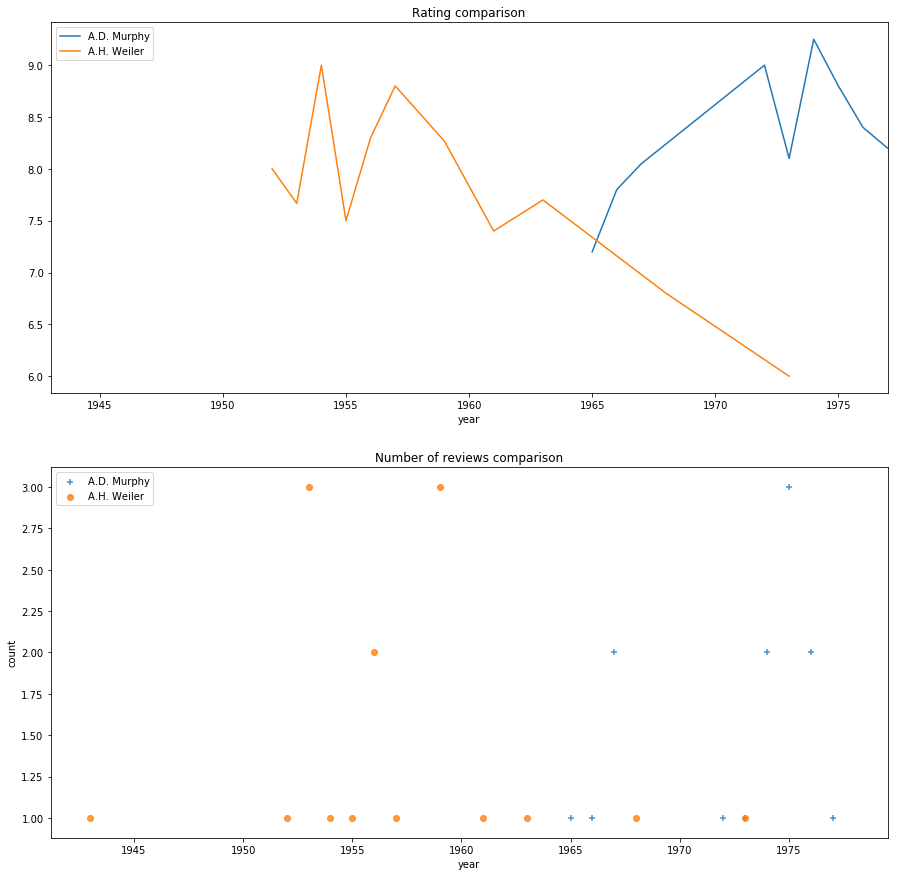

In [15]:
draw_comparison(RateAndCount)
#A.D. Murphy
#A.H. Weiler

## Potential Analysis 

### Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

In [21]:
reviewer_reviews=pd.DataFrame(reviews.groupby(['critic']).count().reset_index().sort_values('fresh'))

In [22]:
reviewer_reviews=pd.DataFrame(reviews.groupby('critic').count())
reviewer_reviews.reset_index(level=0, inplace=True)
reviewer_reviews

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,A.D. Murphy,14,14,14,14,14,14,14
1,A.H. Weiler,17,17,17,17,17,17,17
2,A.O. Scott,10,10,10,10,10,10,10
3,Aaron Hillis,2,2,2,2,2,2,2
4,Abel Green,5,5,5,5,5,5,5
5,Achy Obejas,1,1,1,1,1,1,1
6,Adam Graham,7,7,7,7,7,7,7
7,Adam Markovitz,1,1,1,1,1,1,1
8,Akiva Gottlieb,2,2,2,2,2,2,2
9,Al Brumley,2,2,2,2,2,2,2


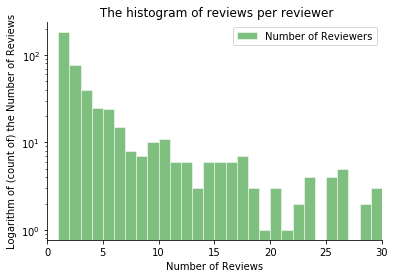

In [23]:
# enter your code here  
%matplotlib inline  
import matplotlib.pyplot as plt 
reviewer_reviews=pd.DataFrame(reviews.groupby('critic').count())
reviewer_reviews.reset_index(level=0, inplace=True)
fig, ax = plt.subplots()
plt.xlim([0, 30])
plt.yscale('log', nonposy='clip')
ax.hist(reviewer_reviews.quote, range=[0,30],bins=30,color=['green'],edgecolor = 'white',alpha=0.5)
plt.ylabel('Logarithm of (count of) the Number of Reviews') # add labels 
plt.xlabel('Number of Reviews')
plt.title(' The histogram of reviews per reviewer')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(['Number of Reviewers'])
plt.show()

In [24]:
import plotly.express as px
import plotly.graph_objs as go
reviewer_reviews.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,A.D. Murphy,14,14,14,14,14,14,14
1,A.H. Weiler,17,17,17,17,17,17,17
2,A.O. Scott,10,10,10,10,10,10,10
3,Aaron Hillis,2,2,2,2,2,2,2
4,Abel Green,5,5,5,5,5,5,5


In [25]:

fig = px.bar(reviewer_reviews, x='critic', y='quote',
             labels={'pop':'population of Canada'}, height=400)
fig.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


###  Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [26]:
Group_Aggregation = reviews[['critic', 'publication', 
                       'review_date', 'quote']].groupby('critic').agg({'review_date': ['max', 'min'], 
                        'publication': ['max'],                                                            'quote': ['count']})
TOP_30_Critics=Group_Aggregation.sort_values(by=[('quote','count')], ascending = False)[:30]
TOP_30_Critics.reset_index(level=0, inplace=True)
TOP_30_Critics

critic review_date                          publication quote
                               max         min                      max count
0          Roger Ebert  2013-06-11  2000-01-01        Chicago Sun-Times  1150
1   James Berardinelli  2012-02-07  1800-01-01                ReelViews   833
2         Janet Maslin  2010-09-07  2000-01-01           New York Times   526
3        Variety Staff  2012-08-15  2001-02-13                  Variety   449
4   Jonathan Rosenbaum  2013-10-22  1988-07-11           Chicago Reader   420
5       Desson Thomson  2012-10-08  2000-01-01          Washington Post   373
6         Geoff Andrew  2012-04-05  2005-08-11                 Time Out   361
7            Dave Kehr  2013-11-20  2000-01-01      New York Daily News   360
8        Kenneth Turan  2013-10-05  2000-01-01        Los Angeles Times   282
9         Mick LaSalle  2009-11-25  2000-01-01  San Francisco Chronicle   280
10     Owen Gleiberman  2011-09-07  1800-01-01     Entertainment Weekly   241
11        Rita Kempley  2013-11-02  2000-01-01          Washington Post   236
12         Joe Baltake  2013-08-04  2000-01-01           Sacramento Bee   231
13       Todd McCarthy  2012-10-09  2000-01-01                  Variety   223
14       Vincent Canby  2013-07-29  2000-01-01           New York Times   207
15          Hal Hinson  2013-06-26  2000-01-01          Washington Post   174
16         Susan Stark  2002-10-25  2000-01-01             Detroit News   167
17      Stephen Holden  2009-02-06  2000-01-01           New York Times   166
18         Derek Adams  2009-10-04  2006-01-26                 Time Out   154
19        Kevin Thomas  2013-11-02  2000-01-01        Los Angeles Times   145
20         Peter Stack  2002-06-18  2000-01-01  San Francisco Chronicle   138
21     Bosley Crowther  2008-05-06  2000-01-01           New York Times   137
22          Rick Groen  2009-08-14  2002-03-19           Globe and Mail   129
23     Edward Guthmann  2003-04-04  2000-01-01  San Francisco Chronicle   121
24    Lisa Schwarzbaum  2012-08-15  1979-01-01     Entertainment Weekly   117
25          Liam Lacey  2012-04-04  2001-08-24           Globe and Mail   111
26        Emanuel Levy  2010-08-06  2000-01-01                  Variety   110
27    Richard Schickel  2013-08-05  2000-01-01             The Atlantic   106
28     Richard Corliss  2013-11-06  2003-12-16            TIME Magazine   104
29  Michael Wilmington  2013-11-21  2000-01-01        Los Angeles Times   103

### Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [ ]:
movies.head(2)

In [ ]:
# set the size of the figure 
plt.figure(figsize=(20,15))
# drop movies with 0
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(lambda x: x if x >0 else None)
# do the scatter plot 
sctr = plt.scatter(movies['year'], movies['rtAllCriticsRating'], c='blue', s=60)
sctr.set_alpha(0.3)
# calculate the average rating by year 
year_rating= pd.DataFrame(movies.groupby('year')['year'].count())
year_rating.columns = ['count']
year_rating['sumRating'] = movies.groupby('year')['rtAllCriticsRating'].sum()
year_rating['avgRating'] = year_rating['sumRating']/year_rating['count']
year_rating.reset_index(level=0, inplace =True)
year_rating = year_rating.dropna()
#  plot a trend in average rating over the year
plt.plot(year_rating['year'],year_rating['avgRating'], c='#6b00b3', color='orange',linewidth=3.0, marker='o', label='Average rating')
plt.legend()
plt.title('Movie ratings distribution and tendency by year(xaxis)')